# testing_chip
4/26

The idea here is to take our attributions and relate it to chip data, let's see what's up!

In [7]:
#so we can easily load in these bed files using a pandas dataframe
import os
import pandas as pd
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pd.read_csv(mydir+file, delimiter = '\t', names=headers)
df.head()

,chr,start,stop,name,score,strand,signal,pval,qval,peak point
0,chr6,47242620,47242870,.,1000,.,503.14665,-1.0,3.3668,136
1,chr16,81752304,81752552,.,1000,.,495.21176,-1.0,3.3668,115
2,chr3,44439835,44440073,.,1000,.,483.20812,-1.0,3.3668,114
3,chr4,182970021,182970260,.,1000,.,479.89343,-1.0,3.3668,120
4,chr7,113142413,113142638,.,1000,.,471.77412,-1.0,3.3668,118


In [9]:
#so let's just stick with this df for now and do the analysis we need to, one of the biggest issues is of course relating the data to the larger one
#so we now have 2 bed files, we can go ahead and find the stuff

#basically for every peak we first find any corresponding cCREs that ar ein our highly variable 10k (can look left or right by 500 from start and end)
#then if there's a match with the chip and highly variable data, we can look at the SPI1 attributions in that cCRE in both models
#so that means have to go from the ccre id to the attributions, not terribly difficult, maybe precompute some sort of hash table!

#but the first step is to see how many of these chip seq peaks corresopnd to the highly variable cCREs, let's start with the K562 of course

#we can do this by getting the start and stop of the highly variable cCREs, which requires taking all the backward steps lol
#start from the indices, that can easily give us the ID from the dataset, that ID can be used to find the start and stop

ccre_df = pl.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', separator='\t', has_header = False)
ccre_df.head()

column_1,column_2,column_3,column_4,column_5,column_6
str,i64,i64,str,str,str
"""chr1""",104896,105048,"""EH38D4327509""","""EH38E2776520""","""CTCF-only,CTCF…"
"""chr1""",138866,139134,"""EH38D4327520""","""EH38E2776521""","""pELS,CTCF-boun…"
"""chr1""",181289,181639,"""EH38D4327525""","""EH38E2776524""","""DNase-H3K4me3,…"
"""chr1""",267925,268171,"""EH38D4327544""","""EH38E2776528""","""CTCF-only,CTCF…"
"""chr1""",586036,586264,"""EH38D4327554""","""EH38E2776532""","""CTCF-only,CTCF…"


In [12]:
ccre_df.shape

(1063878, 6)

In [11]:
#now that we have this, let's go ahead and find the indices
#first up let's compute a hash table that goes from the ID to the index
ccre_to_index = {}
for i in range(len(ccre_df)):
    ccre_id = ccre_df[i,3]
    ccre_to_index[ccre_id] = i
print(len(ccre_to_index.keys()))
#ok it lines up!!

1063878


In [16]:
#yeah looks right! now we can do the hard part of creating a smaller datafram of just the highly variable cCREs!!

#first up let's load in the indices, and then have to translate them to the ID, which won't be that bad, just do what the dataset class does

import numpy as np
train_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train_idx.npy')
val_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/val_idx.npy')
test_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/test_idx.npy')

train_idx = train_idx[train_idx != 752763]

ccre_ids = []
#now get list for each of the 3 separately
data_path = f'/data/leslie/sarthak/data/train.csv'
array = pd.read_csv(data_path).to_numpy() #note this works because we have a header in the csv
for idx in train_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/val.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in val_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/test.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in test_idx:
    ccre_ids.append(array[idx,0])
print(len(ccre_ids))
print(ccre_ids)

9999
['EH38D3697530', 'EH38D5237637', 'EH38D4871903', 'EH38D5843578', 'EH38D3589541', 'EH38D3845414', 'EH38D5576868', 'EH38D3684183', 'EH38D3878893', 'EH38D4018903', 'EH38D2664367', 'EH38D3619422', 'EH38D3484756', 'EH38D3187525', 'EH38D5022575', 'EH38D6056718', 'EH38D6031904', 'EH38D2912026', 'EH38D5223766', 'EH38D5580154', 'EH38D2693158', 'EH38D3630592', 'EH38D5007680', 'EH38D5779310', 'EH38D5450368', 'EH38D3757606', 'EH38D3621816', 'EH38D4317718', 'EH38D2974296', 'EH38D5695249', 'EH38D2250156', 'EH38D2205015', 'EH38D3727969', 'EH38D4946551', 'EH38D5526012', 'EH38D4271458', 'EH38D5772717', 'EH38D2994046', 'EH38D4790960', 'EH38D2244528', 'EH38D5658373', 'EH38D4290297', 'EH38D3195602', 'EH38D6082541', 'EH38D4385182', 'EH38D3735962', 'EH38D2663165', 'EH38D2710599', 'EH38D4839409', 'EH38D5729339', 'EH38D4854734', 'EH38D5479689', 'EH38D5343914', 'EH38D4801149', 'EH38D6103603', 'EH38D4274522', 'EH38D6119491', 'EH38D5256057', 'EH38D3866451', 'EH38D5358596', 'EH38D5646439', 'EH38D5071662', 'E

In [17]:
#now with that above having finished, we can easily index into the polars dataframe and create a smaller one
ccre_row = []
for idx in ccre_ids:
    ccre_row.append(ccre_to_index[idx])
highly_variable_df = ccre_df[np.array(ccre_row),:]

In [18]:
print(highly_variable_df.shape)
highly_variable_df.head()

(9999, 6)


column_1,column_2,column_3,column_4,column_5,column_6
str,i64,i64,str,str,str
"""chr5""",41770833,41771072,"""EH38D3697530""","""EH38E2368817""","""dELS"""
"""chr2""",133198722,133198947,"""EH38D5237637""","""EH38E3372705""","""dELS,CTCF-boun…"
"""chr15""",46766123,46766360,"""EH38D4871903""","""EH38E3132281""","""dELS"""
"""chr7""",33572464,33572790,"""EH38D5843578""","""EH38E3766626""","""dELS"""
"""chr4""",75265201,75265531,"""EH38D3589541""","""EH38E3589451""","""dELS"""


In [29]:
#and add some headers, chr, start, stop, id1, id2, type
headers_highvar = ['chr','start','stop','id1','id2','type']
highly_variable_df.columns = headers_highvar
highly_variable_df.head()

chr,start,stop,id1,id2,type
str,i64,i64,str,str,str
"""chr5""",41770833,41771072,"""EH38D3697530""","""EH38E2368817""","""dELS"""
"""chr2""",133198722,133198947,"""EH38D5237637""","""EH38E3372705""","""dELS,CTCF-boun…"
"""chr15""",46766123,46766360,"""EH38D4871903""","""EH38E3132281""","""dELS"""
"""chr7""",33572464,33572790,"""EH38D5843578""","""EH38E3766626""","""dELS"""
"""chr4""",75265201,75265531,"""EH38D3589541""","""EH38E3589451""","""dELS"""


In [19]:
#so we can easily load in these bed files using a pandas dataframe
import os
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
df.head()

chr,start,stop,name,score,strand,signal,pval,qval,peak point
str,i64,i64,str,i64,str,f64,f64,f64,i64
"""chr6""",47242620,47242870,""".""",1000,""".""",503.14665,-1.0,3.3668,136
"""chr16""",81752304,81752552,""".""",1000,""".""",495.21176,-1.0,3.3668,115
"""chr3""",44439835,44440073,""".""",1000,""".""",483.20812,-1.0,3.3668,114
"""chr4""",182970021,182970260,""".""",1000,""".""",479.89343,-1.0,3.3668,120
"""chr7""",113142413,113142638,""".""",1000,""".""",471.77412,-1.0,3.3668,118


In [36]:
#the above stuff just needs to be run once, now we do a loop where we look at each of the 4 chipseq bed files for the differeent celltypes
#let's first just see how many matches we have!
for tf_peak in range(len(df)):
    peak = df[tf_peak,:]
    # print(peak)
    peak_start = peak['start'][0]
    peak_end = peak['stop'][0]
    chromosome = peak['chr'][0]
    subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
    # print(subset_df.shape)
    # print(subset_df)
    # break
    #now we loop through there and see if start is within 500 of it
    start = subset_df['start'].to_numpy()
    start = start-peak_start
    close = start[np.abs(start)<50000]
    print(close)
    break #here there's only one value that's starting within 50000 of my highly variable cres, that's fine, let's just combine the amount in total

[29983]


In [37]:
num = 0
from tqdm import tqdm
for tf_peak in tqdm(range(len(df)), total = len(df)):
    peak = df[tf_peak,:]
    peak_start = peak['start'][0]
    peak_end = peak['stop'][0]
    chromosome = peak['chr'][0]
    subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
    start = subset_df['start'].to_numpy()
    start = start-peak_start
    close = start[np.abs(start)<500]
    num+=len(close)
print(num)


100%|██████████| 32606/32606 [00:18<00:00, 1783.25it/s]

97


In [38]:
print(subset_df) #an example of how the subset_df looks like, it does contain the ccre name?

shape: (811, 6)
┌──────┬───────────┬───────────┬──────────────┬──────────────┬──────┐
│ chr  ┆ start     ┆ stop      ┆ id1          ┆ id2          ┆ type │
│ ---  ┆ ---       ┆ ---       ┆ ---          ┆ ---          ┆ ---  │
│ str  ┆ i64       ┆ i64       ┆ str          ┆ str          ┆ str  │
╞══════╪═══════════╪═══════════╪══════════════╪══════════════╪══════╡
│ chr1 ┆ 271226    ┆ 271468    ┆ EH38D4327546 ┆ EH38E2776529 ┆ dELS │
│ chr1 ┆ 274329    ┆ 274481    ┆ EH38D4327547 ┆ EH38E2776530 ┆ dELS │
│ chr1 ┆ 727121    ┆ 727350    ┆ EH38D4327570 ┆ EH38E2776536 ┆ dELS │
│ chr1 ┆ 807736    ┆ 807916    ┆ EH38D2115331 ┆ EH38E1310164 ┆ dELS │
│ …    ┆ …         ┆ …         ┆ …            ┆ …            ┆ …    │
│ chr1 ┆ 248566070 ┆ 248566335 ┆ EH38D4482784 ┆ EH38E2879996 ┆ dELS │
│ chr1 ┆ 248570811 ┆ 248571155 ┆ EH38D2303648 ┆ EH38E2879998 ┆ dELS │
│ chr1 ┆ 248589436 ┆ 248589642 ┆ EH38D4482791 ┆ EH38E2880000 ┆ dELS │
│ chr1 ┆ 248830635 ┆ 248830923 ┆ EH38D4482949 ┆ EH38E2880096 ┆ dELS │
└───

In [45]:
#new plan, what if we were to keep the ids from when we filtered it? That way we can easily remember it!!
df = ccre_df.with_columns(
    pl.arange(0, len(ccre_df)).alias('index')
)
print(df)
highly_variable_df = df[np.array(ccre_row),:]

headers_highvar = ['chr','start','stop','id1','id2','type','ccre_idx']
highly_variable_df.columns = headers_highvar
print(highly_variable_df)

shape: (1_063_878, 7)
┌──────────┬──────────┬──────────┬──────────────┬──────────────┬─────────────────────────┬─────────┐
│ column_1 ┆ column_2 ┆ column_3 ┆ column_4     ┆ column_5     ┆ column_6                ┆ index   │
│ ---      ┆ ---      ┆ ---      ┆ ---          ┆ ---          ┆ ---                     ┆ ---     │
│ str      ┆ i64      ┆ i64      ┆ str          ┆ str          ┆ str                     ┆ i64     │
╞══════════╪══════════╪══════════╪══════════════╪══════════════╪═════════════════════════╪═════════╡
│ chr1     ┆ 104896   ┆ 105048   ┆ EH38D4327509 ┆ EH38E2776520 ┆ CTCF-only,CTCF-bound    ┆ 0       │
│ chr1     ┆ 138866   ┆ 139134   ┆ EH38D4327520 ┆ EH38E2776521 ┆ pELS,CTCF-bound         ┆ 1       │
│ chr1     ┆ 181289   ┆ 181639   ┆ EH38D4327525 ┆ EH38E2776524 ┆ DNase-H3K4me3,CTCF-boun ┆ 2       │
│          ┆          ┆          ┆              ┆              ┆ d                       ┆         │
│ chr1     ┆ 267925   ┆ 268171   ┆ EH38D4327544 ┆ EH38E2776528 ┆ CTCF

In [47]:
a = [0,0,0]
print(np.where(a)[0])
print(len(np.where(a)[0]))

[]
0


In [49]:
highly_variable_df.head()

chr,start,stop,id1,id2,type,ccre_idx
str,i64,i64,str,str,str,i64
"""chr5""",41770833,41771072,"""EH38D3697530""","""EH38E2368817""","""dELS""",890600
"""chr2""",133198722,133198947,"""EH38D5237637""","""EH38E3372705""","""dELS,CTCF-boun…",980081
"""chr15""",46766123,46766360,"""EH38D4871903""","""EH38E3132281""","""dELS""",819124
"""chr7""",33572464,33572790,"""EH38D5843578""","""EH38E3766626""","""dELS""",1010151
"""chr4""",75265201,75265531,"""EH38D3589541""","""EH38E3589451""","""dELS""",536278


In [50]:
#let's redefine df
#so we can easily load in these bed files using a pandas dataframe
import os
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
df.head()

chr,start,stop,name,score,strand,signal,pval,qval,peak point
str,i64,i64,str,i64,str,f64,f64,f64,i64
"""chr6""",47242620,47242870,""".""",1000,""".""",503.14665,-1.0,3.3668,136
"""chr16""",81752304,81752552,""".""",1000,""".""",495.21176,-1.0,3.3668,115
"""chr3""",44439835,44440073,""".""",1000,""".""",483.20812,-1.0,3.3668,114
"""chr4""",182970021,182970260,""".""",1000,""".""",479.89343,-1.0,3.3668,120
"""chr7""",113142413,113142638,""".""",1000,""".""",471.77412,-1.0,3.3668,118


In [51]:
#we will have to figure out train vs val vs test from the chromosome, this is actually relatively straightforward comparitively!
#wait we will also have to do ccre_idx - len(train set) for val and ccre_idx-len(train)-len(val) for the test... uh oh!

from tqdm import tqdm
for tf_peak in tqdm(range(len(df)), total = len(df)):
    peak = df[tf_peak,:]
    peak_start = peak['start'][0]
    peak_end = peak['stop'][0]
    chromosome = peak['chr'][0]
    subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
    start = subset_df['start'].to_numpy()
    start = start-peak_start
    close = np.abs(start)<500
    locations = np.where(close)[0] #provides all the locations
    if len(locations)==0: #if there's no locations we don't care
        continue
    #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
    newdf = subset_df[locations,:]
    if len(locations>1):
        raise ValueError('idk wtf to do with 2 of them')
    #if it's just 1 result, we can easily find the ccre_idx and use the chromosome to determine which one it is!

  2%|▏         | 556/32606 [00:00<00:24, 1291.89it/s]

shape: (1, 7)
┌───────┬──────────┬──────────┬──────────────┬──────────────┬──────┬──────────┐
│ chr   ┆ start    ┆ stop     ┆ id1          ┆ id2          ┆ type ┆ ccre_idx │
│ ---   ┆ ---      ┆ ---      ┆ ---          ┆ ---          ┆ ---  ┆ ---      │
│ str   ┆ i64      ┆ i64      ┆ str          ┆ str          ┆ str  ┆ i64      │
╞═══════╪══════════╪══════════╪══════════════╪══════════════╪══════╪══════════╡
│ chr14 ┆ 20494242 ┆ 20494396 ┆ EH38D4799776 ┆ EH38E3085262 ┆ dELS ┆ 205493   │
└───────┴──────────┴──────────┴──────────────┴──────────────┴──────┴──────────┘


In [53]:
#here's the moment of truth, can we check to see 205493 here is indeed a dELS, but is it the one we want?
#this is probably in the train set! 11 and 12 are used for test, val is 8 and 10. here's the big issue...
#if we got it in alphabetical order... easier strat is just use the ID and index into the train set
#so that's what we'll do
#for now use np.where, but later we will make it a proper dictionary
ccre_id = 'EH38D4799776'
#now we can look at our train array
data_path = f'/data/leslie/sarthak/data/train.csv'
array = pd.read_csv(data_path).to_numpy()
a = np.where(array[:,0] == ccre_id) #this part alone takes like 20 seconds, it's string compare man!
a
#have to do this separately for train test and validation, but this will throw an error so not too worried

(array([91154]),)

In [54]:
#now let's try this
array[a]

array([['EH38D4799776', 14,
        'ACTCTTCCTCAAAACTGCTAGTGTCTTGCAGAtcctctctcaaaacaaaagaggaagtcagaggtGGAGCAGGGAGTGGTTTGAACTACTGGTTTTACTGGAAAAGGATTCCTGTTCCAAACCTCAAGAGCAAGTTCTTCGATCTTGAGCAGGAAAGAATTAAGGACAGGGCGCAGAGTACAGTATAGTTAAAACAGTTCATTAGAAACTACTCTATTACAGAGTAGGGCATCCTCAGAGAGCAAGAGGAGGAATGCCCCTACTTTAAATGTAATGCTTGCTTATACAGGATATTAAGGTTAAGAATAGTttactttgggagtccgaggtgggtggatcacgaggtcaggagatcaagaccatcctggctaacacggtgaaaccccatctccactaaaaatacaaaaaattagccgggcatggtggtgggcacctgtagtcccagctactcgggaggctaaggcaggagaatggcatgaatccgggtggcggagcttgcagtgaaccgagattgcgccactgcacttcagtctgggcaacagagccagactccatctcaaaaaaaaaaaaaaaaaaaaaaaaaagaatagtttacTTTATTATAAAGGCTTGTGATCAAGTTGTGACAGGCTATTAGTATTGTTATTCTCCGGTGTAACTATTGATTTCAGCAATAATTTATGAGTGTAGTATTATCTTTAAAGTGAAacccatgtttatttttatgtgtttatttgcttaCACCTTCACCACCACAAGAAACCCTCCcacccacctttttttttaagacagaatttcactcttgtcgcccaggctggagtgcagtggtgcgatcttggctcactgtagcctccacctccttgaCTCGATCCTCTTTGATCCTCtggattctctcacctcagtctccatgcccagctaatttttatttttatttttttatagagataggattCTACCATGTTG

In [55]:
#I think that means our key is 91154, it is indeed in the msot variable ccre list!!
#what that now means is that we can easily just take this and find where in the train_idx it is
np.where(train_idx == 91154)

(array([3781]),)

In [ ]:
#this is the specific number where we index into the thing!! The fimo_summary thing! This is the specific CRE!!!

#IMPORTANT, we also have to be sure to consider going into val_idx or test_idx if it is from that chormosome!

In [ ]:
#so in total we get 100 matches?? out of 36000?? oh well dude, I guess it's to be expected
#so if we have a match, we then check that CRE to see what the FIMO attributions are for it
load = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/fimo_summary_bothmodel.npz')
fimo_summary,fimo_summary_mult = load['fimo_summary'], load['fimo_summary_mult']
spi1 = fimo_summary[:,466,:]
spi1_mult = fimo_summary_mult[:,466,:]
#now we need to find a way to relate this, so above we explored how to get the ccreID, that can be used by going into train_idx, or val_idx etc.
#that will tell you which part of the array this is from!!

# now doing the analysis

In [ ]:
#so now we have the tools for the pipeline, for each bed file, we then loop through each individual ccre, see if it matches, and if it does,
#we take it out and find where in the fimo summary it actually is, then we easily just index in like that!!

#but now it's a double for loop and in that inner second loop, lots of steps to actually find which index of the fimo_summary it is!

#then we can do AUCROC or any sort of binary classification, each CRE is 0 except for the ones that we find, those ones get set to 1 as the labels
#and then our attribution scores (or negative of the attribution scores) are used for the 'score' of our model!! Some sort of validation!!
#even tho chip is not pefect at all!!

#actually we can use the list of ccre_ids to more easily access the index of the fimo_summary, that's a good idea!

#IMPORTANT, make sure all of my steps account for val and test, particularly which one we index into 


In [3]:
#all the steps

#so we can easily load in these bed files using a pandas dataframe
import os
import pandas as pd
import polars as pl
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
# df.head()

ccre_df = pl.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', separator='\t', has_header = False)
# ccre_df.head()
#now that we have this, let's go ahead and find the indices
#first up let's compute a hash table that goes from the ID to the index
ccre_to_index = {}
for i in range(len(ccre_df)):
    ccre_id = ccre_df[i,3]
    ccre_to_index[ccre_id] = i
# print(len(ccre_to_index.keys()))
#ok it lines up!!

import numpy as np
train_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train_idx.npy')
val_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/val_idx.npy')
test_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/test_idx.npy')

train_idx = train_idx[train_idx != 752763]

ccre_ids = []
#now get list for each of the 3 separately
data_path = f'/data/leslie/sarthak/data/train.csv'
array = pd.read_csv(data_path).to_numpy() #note this works because we have a header in the csv
for idx in train_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/val.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in val_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/test.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in test_idx:
    ccre_ids.append(array[idx,0])

highvar_ccre_id_to_idx = {}
for i in range(len(ccre_ids)):
    highvar_ccre_id_to_idx[ccre_ids[i]] = i


In [18]:
highvar_ccre_id_to_idx = {}
for i in range(len(ccre_ids)):
    highvar_ccre_id_to_idx[ccre_ids[i]] = i
print(len(highvar_ccre_id_to_idx.keys()))

9999


In [16]:
len(ccre_to_index.keys()) #this is for all of them

1063878

In [8]:
len(ccre_ids) #ahh, this is perfect!

9999

In [9]:
ccre_row = []
for idx in ccre_ids:
    ccre_row.append(ccre_to_index[idx])
highly_variable_df = ccre_df[np.array(ccre_row),:]
# tempdf = ccre_df.with_columns(
#     pl.arange(0, len(ccre_df)).alias('index')
# )
# highly_variable_df = tempdf[np.array(ccre_row),:]

# headers_highvar = ['chr','start','stop','id1','id2','type','ccre_idx']
headers_highvar = ['chr','start','stop','id1','id2','type']
highly_variable_df.columns = headers_highvar
print(highly_variable_df)

shape: (9_999, 6)
┌───────┬───────────┬───────────┬──────────────┬──────────────┬─────────────────┐
│ chr   ┆ start     ┆ stop      ┆ id1          ┆ id2          ┆ type            │
│ ---   ┆ ---       ┆ ---       ┆ ---          ┆ ---          ┆ ---             │
│ str   ┆ i64       ┆ i64       ┆ str          ┆ str          ┆ str             │
╞═══════╪═══════════╪═══════════╪══════════════╪══════════════╪═════════════════╡
│ chr5  ┆ 41770833  ┆ 41771072  ┆ EH38D3697530 ┆ EH38E2368817 ┆ dELS            │
│ chr2  ┆ 133198722 ┆ 133198947 ┆ EH38D5237637 ┆ EH38E3372705 ┆ dELS,CTCF-bound │
│ chr15 ┆ 46766123  ┆ 46766360  ┆ EH38D4871903 ┆ EH38E3132281 ┆ dELS            │
│ chr7  ┆ 33572464  ┆ 33572790  ┆ EH38D5843578 ┆ EH38E3766626 ┆ dELS            │
│ …     ┆ …         ┆ …         ┆ …            ┆ …            ┆ …               │
│ chr11 ┆ 1953525   ┆ 1953738   ┆ EH38D4575731 ┆ EH38E2939787 ┆ dELS,CTCF-bound │
│ chr12 ┆ 105304699 ┆ 105304923 ┆ EH38D2601481 ┆ EH38E1640199 ┆ dELS            

In [10]:
#now is the part where we actually do it for one of the celltypes


from tqdm import tqdm
for tf_peak in tqdm(range(len(df)), total = len(df)):
    peak = df[tf_peak,:]
    peak_start = peak['start'][0]
    peak_end = peak['stop'][0]
    chromosome = peak['chr'][0]
    subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
    start = subset_df['start'].to_numpy()
    start = start-peak_start
    close = np.abs(start)<500
    locations = np.where(close)[0] #provides all the locations
    if len(locations)==0: #if there's no locations we don't care
        continue
    #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
    newdf = subset_df[locations,:]
    if len(locations)>1:
        raise ValueError('idk wtf to do with 2 of them')
    #if it's just 1 result, we can easily find the ccre_idx and use the chromosome to determine which one it is!
    break

  0%|          | 0/32606 [00:00<?, ?it/s]

  2%|▏         | 556/32606 [00:00<00:23, 1356.64it/s]


ValueError: idk wtf to do with 2 of them

In [14]:
newdf

chr,start,stop,id1,id2,type
str,i64,i64,str,str,str
"""chr14""",20494242,20494396,"""EH38D4799776""","""EH38E3085262""","""dELS"""


In [19]:
newdf['id1'][0]

'EH38D4799776'

In [20]:
highvar_ccre_id_to_idx[newdf['id1'][0]]
#same answer, it's the same CRE!!! this means fimo_summary[3781,466,K562] is the attributions for this CRE for spi1 for the k562 cell!!
#need to find k562 id tho!

3781

In [21]:
#now is the part where we actually do it for one of the celltypes


from tqdm import tqdm
for tf_peak in tqdm(range(len(df)), total = len(df)):
    peak = df[tf_peak,:]
    peak_start = peak['start'][0]
    peak_end = peak['stop'][0]
    chromosome = peak['chr'][0]
    subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
    start = subset_df['start'].to_numpy()
    start = start-peak_start
    close = np.abs(start)<500
    locations = np.where(close)[0] #provides all the locations
    if len(locations)==0: #if there's no locations we don't care
        continue
    #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
    newdf = subset_df[locations,:]
    if len(locations)>1:
        raise ValueError('idk wtf to do with 2 of them')
    #if it's just 1 result, we can easily find the ccre_idx and use the chromosome to determine which one it is!
    # break

 12%|█▏        | 3782/32606 [00:02<00:21, 1370.06it/s]


ValueError: idk wtf to do with 2 of them

In [23]:
newdf

chr,start,stop,id1,id2,type
str,i64,i64,str,str,str
"""chr19""",34920400,34920551,"""EH38D5128696""","""EH38E3302123""","""dELS,CTCF-boun…"
"""chr19""",34920564,34920765,"""EH38D5128697""","""EH38E3302124""","""dELS"""


In [25]:
len(newdf)

2

In [26]:
#we can literally just make a list of this for the k562 cell!!
#and then do a for loop, but let's make this for the k562 cell first
k562_list = []

for tf_peak in tqdm(range(len(df)), total = len(df)):
    peak = df[tf_peak,:]
    peak_start = peak['start'][0]
    peak_end = peak['stop'][0]
    chromosome = peak['chr'][0]
    subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
    start = subset_df['start'].to_numpy()
    start = start-peak_start
    close = np.abs(start)<500
    locations = np.where(close)[0] #provides all the locations
    if len(locations)==0: #if there's no locations we don't care
        continue
    #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
    newdf = subset_df[locations,:]
    # if len(locations)>1:
    #     raise ValueError('idk wtf to do with 2 of them')
    for i in range(len(newdf)):
        k562_list.append(newdf['id1'][i])
print(len(k562_list))

100%|██████████| 32606/32606 [00:23<00:00, 1377.07it/s]

97


In [27]:
k562_list

['EH38D4799776',
 'EH38D4387271',
 'EH38D4703646',
 'EH38D5423833',
 'EH38D5867241',
 'EH38D3172102',
 'EH38D5945743',
 'EH38D2427461',
 'EH38D4778170',
 'EH38D5200427',
 'EH38D3561247',
 'EH38D6087157',
 'EH38D5128696',
 'EH38D5128697',
 'EH38D5746681',
 'EH38D4459097',
 'EH38D6099753',
 'EH38D2779980',
 'EH38D2779981',
 'EH38D3984573',
 'EH38D5333314',
 'EH38D3155561',
 'EH38D3172102',
 'EH38D3189080',
 'EH38D5790693',
 'EH38D5765361',
 'EH38D4429159',
 'EH38D4429160',
 'EH38D4269286',
 'EH38D4269287',
 'EH38D5381943',
 'EH38D5649362',
 'EH38D3834781',
 'EH38D4433113',
 'EH38D5725432',
 'EH38D5421849',
 'EH38D5156605',
 'EH38D4597525',
 'EH38D3110164',
 'EH38D5530318',
 'EH38D4878491',
 'EH38D4819328',
 'EH38D2644347',
 'EH38D2575221',
 'EH38D3830512',
 'EH38D5943788',
 'EH38D4416901',
 'EH38D5641040',
 'EH38D4419228',
 'EH38D4419229',
 'EH38D4352915',
 'EH38D4423239',
 'EH38D4360766',
 'EH38D5493319',
 'EH38D4390805',
 'EH38D5240595',
 'EH38D2140744',
 'EH38D5953392',
 'EH38D4635903

In [28]:
templist = []
for i in k562_list:
    templist.append(highvar_ccre_id_to_idx[i])
print(templist)

[3781, 2529, 9303, 5323, 7693, 134, 8852, 9410, 622, 2886, 5513, 5605, 7775, 6601, 6325, 1190, 3848, 1951, 4035, 1308, 5945, 6918, 134, 2351, 367, 2864, 4908, 931, 4388, 4758, 670, 4635, 1711, 7164, 72, 5557, 6260, 9383, 3705, 795, 6074, 3970, 6087, 9250, 1828, 9103, 7787, 648, 7049, 5785, 1322, 2049, 4582, 4475, 1593, 6038, 2625, 8462, 9860, 6865, 2322, 2953, 993, 1055, 6673, 8772, 4642, 7640, 3521, 1561, 4993, 1488, 1101, 4614, 5583, 5318, 5095, 5303, 7547, 3277, 5320, 5117, 5754, 3310, 9774, 7649, 3138, 3386, 1006, 8628, 7586, 9964, 1363, 3146, 7229, 9968, 9590]


In [29]:
#now index into fimo_summary with this information
load = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/fimo_summary_bothmodel.npz')
fimo_summary,fimo_summary_mult = load['fimo_summary'], load['fimo_summary_mult']
spi1 = fimo_summary[:,466,:]
spi1_mult = fimo_summary_mult[:,466,:]
print(spi1.shape)

(9999, 161)


In [31]:
#now index in, note that k562 is index 83 since it's line 84
k562_list = np.array(templist)
spi1k562 = fimo_summary[k562_list,466,83]
print(spi1k562.shape)
spi1k562_mult = fimo_summary_mult[k562_list,466,83]

(97,)


In [32]:
#ok now let's see which one is higher
print(np.mean(spi1k562), np.mean(spi1k562_mult))

-0.005965379 -0.0012136587


(array([ 1.,  0.,  2.,  0.,  1.,  1.,  4., 23., 59.,  6.]),
 array([-0.14929199, -0.1310852 , -0.11287842, -0.09467163, -0.07646485,
        -0.05825806, -0.04005127, -0.02184448, -0.0036377 ,  0.01456909,
         0.03277588]),
 <BarContainer object of 10 artists>)

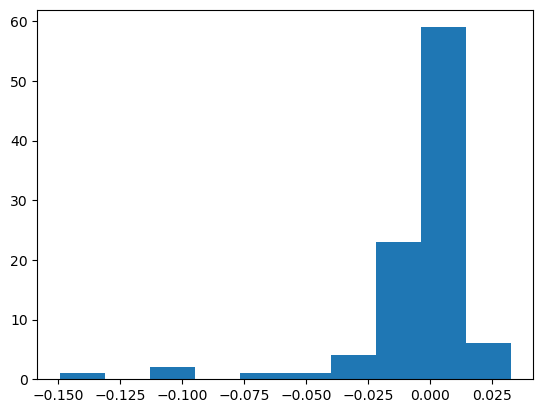

In [33]:
import matplotlib.pyplot as plt
plt.hist(spi1k562)

(array([ 2.,  1.,  0.,  1.,  3.,  9., 65., 12.,  2.,  2.]),
 array([-0.04638672, -0.03934631, -0.03230591, -0.0252655 , -0.0182251 ,
        -0.01118469, -0.00414429,  0.00289612,  0.00993652,  0.01697693,
         0.02401733]),
 <BarContainer object of 10 artists>)

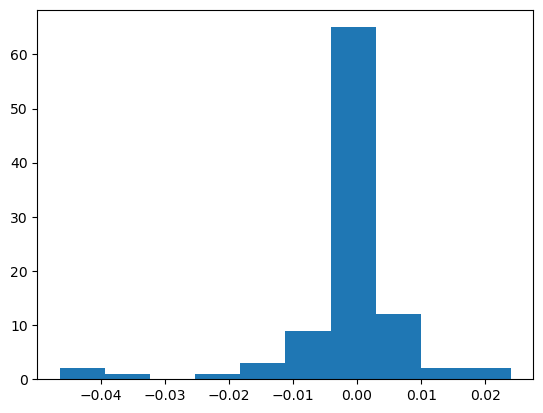

In [34]:
plt.hist(spi1k562_mult)

#maybe this is to be expected, it doesn't really find it for k52, attributions are centered around zero if not slightly negative for both models, let's check other scelltypes like GM and HL

In [ ]:
#let's make the proper loop that saves it all

# condense into a proper loop

In [ ]:
#now we have all the code, let's put it together!!
#all the steps

#so we can easily load in these bed files using a pandas dataframe
import os
import pandas as pd
import polars as pl

ccre_df = pl.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', separator='\t', has_header = False)
# ccre_df.head()
#now that we have this, let's go ahead and find the indices
#first up let's compute a hash table that goes from the ID to the index
ccre_to_index = {}
for i in range(len(ccre_df)):
    ccre_id = ccre_df[i,3]
    ccre_to_index[ccre_id] = i
# print(len(ccre_to_index.keys()))
#ok it lines up!!

import numpy as np
train_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train_idx.npy')
val_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/val_idx.npy')
test_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/test_idx.npy')

train_idx = train_idx[train_idx != 752763]

ccre_ids = []
#now get list for each of the 3 separately
data_path = f'/data/leslie/sarthak/data/train.csv'
array = pd.read_csv(data_path).to_numpy() #note this works because we have a header in the csv
for idx in train_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/val.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in val_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/test.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in test_idx:
    ccre_ids.append(array[idx,0])

highvar_ccre_id_to_idx = {}
for i in range(len(ccre_ids)):
    highvar_ccre_id_to_idx[ccre_ids[i]] = i

ccre_row = []
for idx in ccre_ids:
    ccre_row.append(ccre_to_index[idx])
highly_variable_df = ccre_df[np.array(ccre_row),:]
headers_highvar = ['chr','start','stop','id1','id2','type']
highly_variable_df.columns = headers_highvar

#now index into fimo_summary with this information
load = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/fimo_summary_bothmodel.npz')
fimo_summary,fimo_summary_mult = load['fimo_summary'], load['fimo_summary_mult']
spi1 = fimo_summary[:,466,:]
spi1_mult = fimo_summary_mult[:,466,:]
print(spi1.shape)

In [35]:
#we can literally just make a list of this for the k562 cell!!
#and then do a for loop, but let's make this for the k562 cell first
all_list = []
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
    print(file)
    celltype_list = []
    for tf_peak in tqdm(range(len(df)), total = len(df)):
        peak = df[tf_peak,:]
        peak_start = peak['start'][0]
        peak_end = peak['stop'][0]
        chromosome = peak['chr'][0]
        subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
        start = subset_df['start'].to_numpy()
        start = start-peak_start
        close = np.abs(start)<500
        locations = np.where(close)[0] #provides all the locations
        if len(locations)==0: #if there's no locations we don't care
            continue
        #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
        newdf = subset_df[locations,:]
        for i in range(len(newdf)):
            celltype_list.append(newdf['id1'][i])
    all_list.append(celltype_list)
# print(len(k562_list))

GM12878.bed


100%|██████████| 44283/44283 [00:33<00:00, 1334.81it/s]


GM12891.bed


100%|██████████| 54271/54271 [00:40<00:00, 1334.55it/s]


HL60.bed


100%|██████████| 63379/63379 [00:47<00:00, 1331.69it/s]


K562.bed


100%|██████████| 32606/32606 [00:24<00:00, 1335.58it/s]


In [36]:
for i in all_list:
    print(len(i)) #order is gm12878, 12891, hl60 and k562

220
297
287
97


In [40]:
names_list = np.array(all_list[0])
gm12878_list = []
for name in names_list:
    gm12878_list.append(highvar_ccre_id_to_idx[name])

In [41]:
#now let's go through the first one and plot the mean, gm12878is line 55 so index 54
# gm12878_list = np.array(all_list[0])
spi1gm12878 = fimo_summary[gm12878_list,466,54]
spi1gm12878_mult = fimo_summary_mult[gm12878_list,466,54]
print(np.mean(spi1gm12878,spi1gm12878_mult))

TypeError: only integer scalar arrays can be converted to a scalar index

In [45]:
print(np.mean(spi1gm12878),np.mean(spi1gm12878_mult))

-0.038246125 -0.014020814


(array([  2.,   2.,   5.,   6.,   5.,  13.,  14.,  18., 146.,   9.]),
 array([-0.11230469, -0.0998085 , -0.08731232, -0.07481613, -0.06231995,
        -0.04982376, -0.03732758, -0.02483139, -0.01233521,  0.00016098,
         0.01265717]),
 <BarContainer object of 10 artists>)

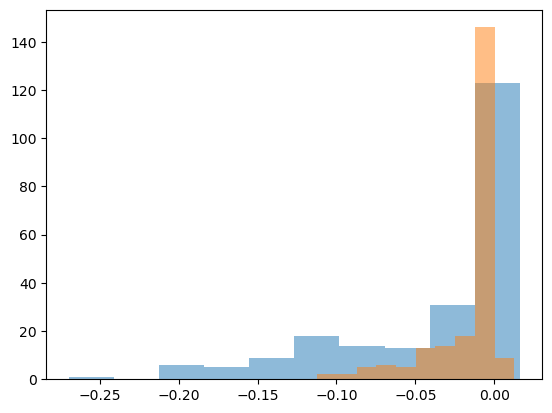

In [46]:
plt.hist(spi1gm12878, alpha=.5)
plt.hist(spi1gm12878_mult,alpha=.5)

In [52]:
names_list = np.array(all_list[1])
gm12891_list = []
for name in names_list:
    gm12891_list.append(highvar_ccre_id_to_idx[name])
#now let's go through the first one and plot the mean, gm12878is line 55 so index 54
# gm12878_list = np.array(all_list[0])
spi1gm12891 = fimo_summary[gm12891_list,466,54]
spi1gm12891_mult = fimo_summary_mult[gm12891_list,466,54]
print(np.mean(spi1gm12891),np.mean(spi1gm12891_mult))

-0.037527483 -0.015244399


(array([  4.,   5.,   4.,  12.,   4.,  19.,  20.,  28., 181.,  20.]),
 array([-0.11230469, -0.0998085 , -0.08731232, -0.07481613, -0.06231995,
        -0.04982376, -0.03732758, -0.02483139, -0.01233521,  0.00016098,
         0.01265717]),
 <BarContainer object of 10 artists>)

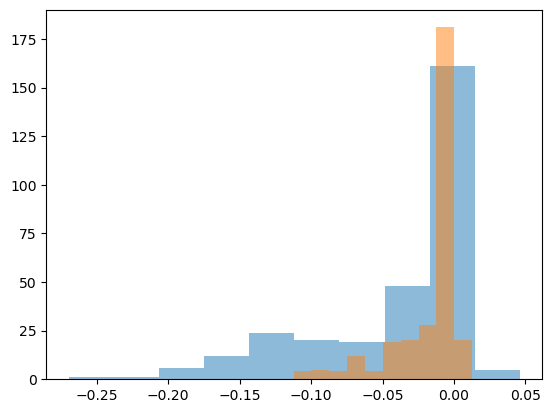

In [53]:
plt.hist(spi1gm12891, alpha=.5)
plt.hist(spi1gm12891_mult,alpha=.5)

-0.031820375 -0.009979613


(array([  2.,   2.,   4.,   7.,   5.,  12.,  18.,  38., 178.,  21.]),
 array([-0.11230469, -0.09928437, -0.08626404, -0.07324371, -0.06022339,
        -0.04720306, -0.03418274, -0.02116241, -0.00814209,  0.00487824,
         0.01789856]),
 <BarContainer object of 10 artists>)

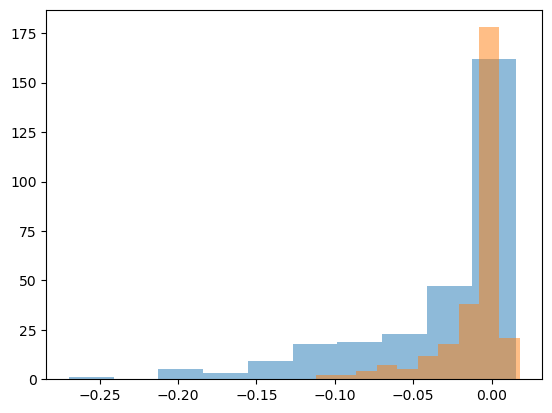

In [54]:
names_list = np.array(all_list[2])
gm12891_list = []
for name in names_list:
    gm12891_list.append(highvar_ccre_id_to_idx[name])
#now let's go through the first one and plot the mean, gm12878is line 55 so index 54
# gm12878_list = np.array(all_list[0])
spi1gm12891 = fimo_summary[gm12891_list,466,54]
spi1gm12891_mult = fimo_summary_mult[gm12891_list,466,54]
print(np.mean(spi1gm12891),np.mean(spi1gm12891_mult))
plt.hist(spi1gm12891, alpha=.5)
plt.hist(spi1gm12891_mult,alpha=.5)

In [ ]:
#just to get an idea, we can do a histogram

-0.023130834 -0.0065901754


(array([ 1.,  1.,  2.,  0.,  0.,  4., 11., 16., 55.,  7.]),
 array([-0.08685303, -0.0765213 , -0.06618957, -0.05585785, -0.04552612,
        -0.0351944 , -0.02486267, -0.01453094, -0.00419922,  0.00613251,
         0.01646423]),
 <BarContainer object of 10 artists>)

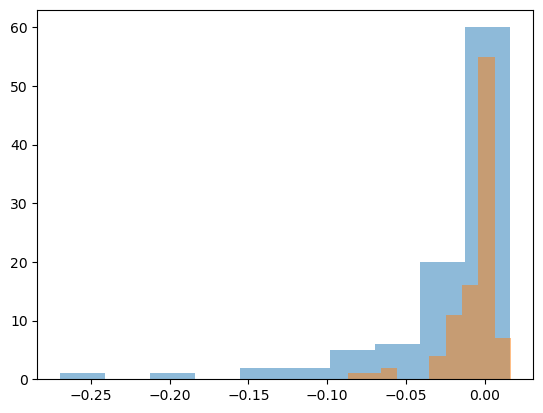

In [55]:
names_list = np.array(all_list[3])
gm12891_list = []
for name in names_list:
    gm12891_list.append(highvar_ccre_id_to_idx[name])
#now let's go through the first one and plot the mean, gm12878is line 55 so index 54
# gm12878_list = np.array(all_list[0])
spi1gm12891 = fimo_summary[gm12891_list,466,54]
spi1gm12891_mult = fimo_summary_mult[gm12891_list,466,54]
print(np.mean(spi1gm12891),np.mean(spi1gm12891_mult))
plt.hist(spi1gm12891, alpha=.5)
plt.hist(spi1gm12891_mult,alpha=.5)

# WAIT!!!
We need to flip the results, so lots of high positive attributions in these regions!! Let's compare it overall tho like for k562 cells

Also by indexing with 54, we're actually getting the GM12878 cell, let's stick with that I guess

NameError: name 'fimo_sumamry_mult' is not defined

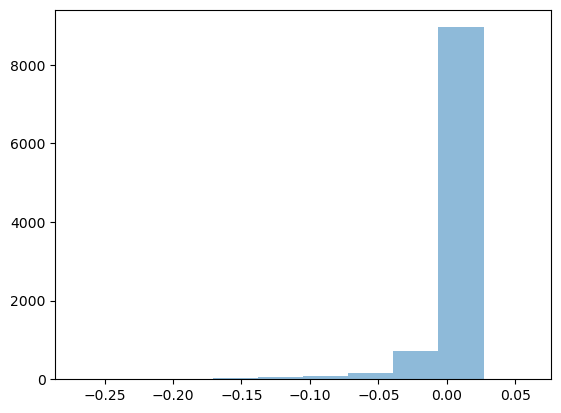

In [56]:
#54 celltype is GM12878!
plt.hist(fimo_summary[:,466,54], alpha=.5)
plt.hist(fimo_sumamry_mult[:,466,54],alpha=.5)

In [ ]:
#that 0.25 can't be a coincidence, can it?!???

In [73]:
#next steps

#we need to now subset each one but flip it, then we compare the group that is positive as the true positives and the group that is negative
#we have to make sure it's flipped of course!!!

#so let's start with K562 cells of all cells
names_list = np.array(all_list[0])
gm12878_list = []
for name in names_list:
    gm12878_list.append(highvar_ccre_id_to_idx[name])
gm12878 = np.array(gm12878_list)


In [74]:
#so now we try to calculate ROC curve, remember to flip by -1!!
full_vector = -fimo_summary[:,466,54]
full_vector_mult = -fimo_summary_mult[:,466,54]

In [75]:
labels = np.zeros_like(full_vector)
labels[gm12878] = 1
print(labels)

[0. 0. 0. ... 0. 0. 0.]


0.7275564409030545


(0.0, 1.05)

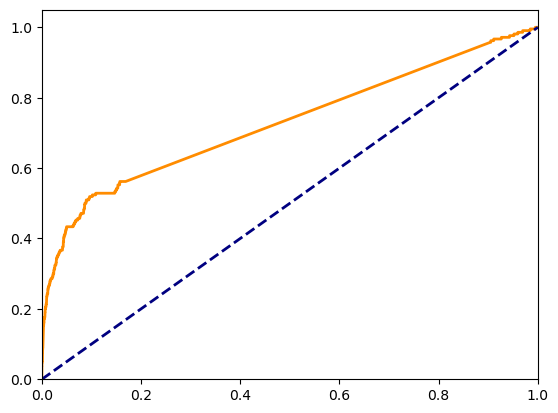

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score
auc = roc_auc_score(labels,full_vector)
print(auc)
fpr, tpr, thresholds = roc_curve(labels, full_vector)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

0.722753917176228


(0.0, 1.05)

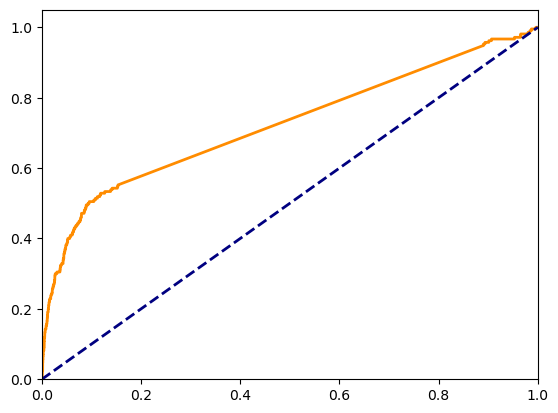

In [77]:
auc = roc_auc_score(labels,full_vector_mult)
print(auc)
fpr, tpr, thresholds = roc_curve(labels, full_vector_mult)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

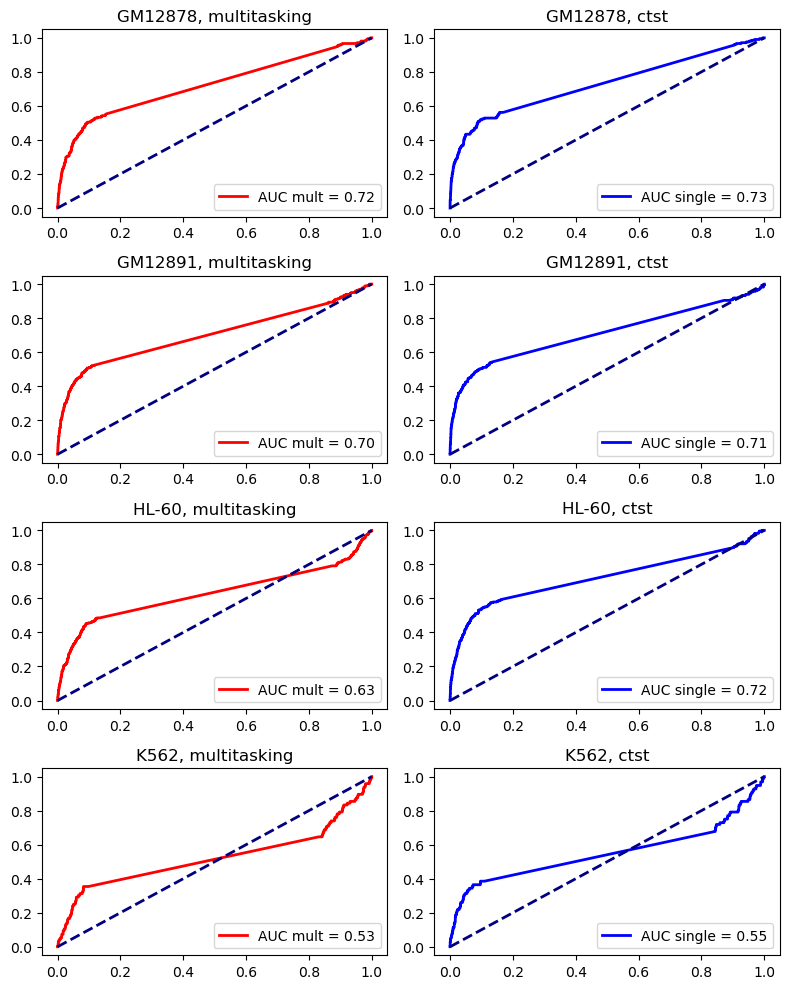

In [72]:
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    fpr, tpr, _ = roc_curve(labels, full_vector)
    roc_auc = roc_auc_score(labels, full_vector)
    fpr_mult, tpr_mult, _ = roc_curve(labels, full_vector_mult)
    roc_auc_mult = roc_auc_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC single = {roc_auc:.2f}')
    ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="lower right")

    ax[row, 0].plot(fpr_mult, tpr_mult, color='red', lw=2, label=f'AUC mult = {roc_auc_mult:.2f}')
    ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="lower right")

# Adjust layout
fig.tight_layout()
plt.show()
    

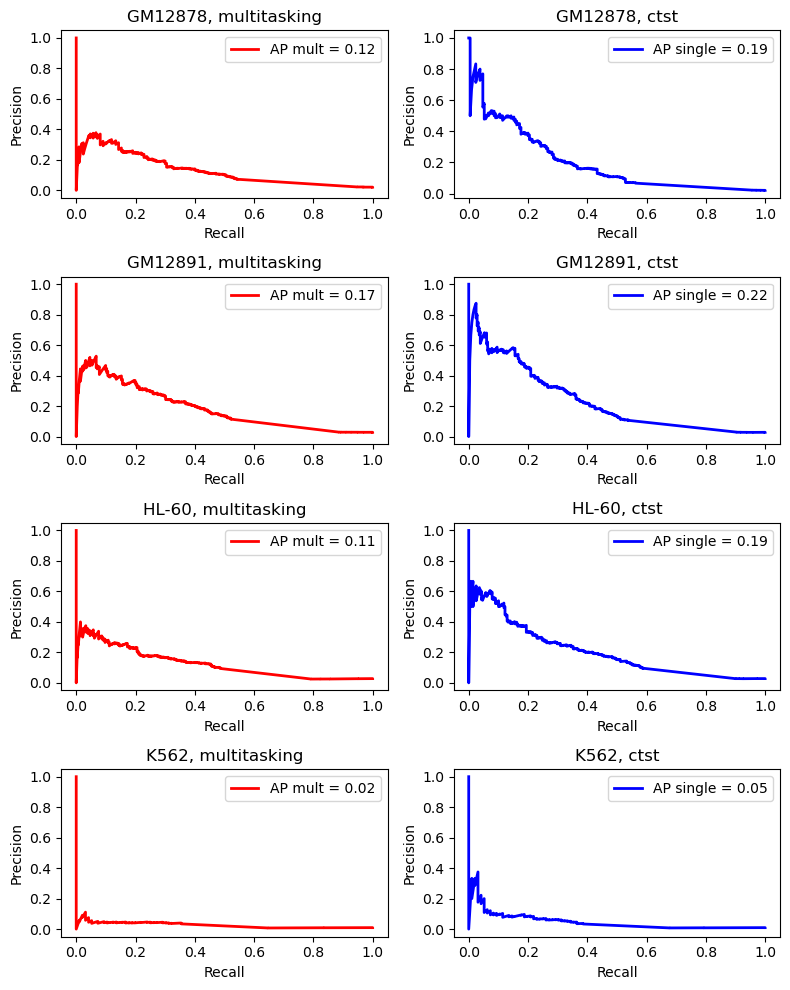

In [80]:
#now the real task is calculating the prc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    precision,recall,_ = precision_recall_curve(labels, full_vector)

    roc_auc = average_precision_score(labels, full_vector)
    precision_mult,recall_mult, _ = precision_recall_curve(labels, full_vector_mult)
    roc_auc_mult = average_precision_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(recall,precision, color='blue', lw=2, label=f'Average precision = {roc_auc:.2f}')
    # ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="upper right")
    ax[row, 1].set_xlabel('Recall')
    ax[row, 1].set_ylabel('Precision')

    ax[row, 0].plot(recall_mult, precision_mult, color='red', lw=2, label=f'Average precision = {roc_auc_mult:.2f}')
    # ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="upper right")
    ax[row, 0].set_xlabel('Recall')
    ax[row, 0].set_ylabel('Precision')

# Adjust layout
fig.tight_layout()
plt.show()

In [ ]:
#we of course don't expect perfect results, it was not trained on this CHIP data, just the encode atac seq data
#but does a decent job of recognizing chip, and shows that clel type specific is much better!!
#particularly better for one cell type!!

# let's redo it but with 500 from the start or end!
so basically that measn we do start-start and start-end, and remove any overlapping ones??  
Actually it should be fine if labels repeats! It would just set it to one twice  
Surely there's a proper way to do this tho, let's think about it...

In [1]:
#let's redo it all, the goal again is to recreate the above but proper!
import os
import pandas as pd
import polars as pl

ccre_df = pl.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', separator='\t', has_header = False)
ccre_to_index = {}
for i in range(len(ccre_df)):
    ccre_id = ccre_df[i,3]
    ccre_to_index[ccre_id] = i

import numpy as np
train_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train_idx.npy')
val_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/val_idx.npy')
test_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/test_idx.npy')

train_idx = train_idx[train_idx != 752763]

ccre_ids = []
data_path = f'/data/leslie/sarthak/data/train.csv'
array = pd.read_csv(data_path).to_numpy() #note this works because we have a header in the csv
for idx in train_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/val.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in val_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/test.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in test_idx:
    ccre_ids.append(array[idx,0])

highvar_ccre_id_to_idx = {}
for i in range(len(ccre_ids)):
    highvar_ccre_id_to_idx[ccre_ids[i]] = i

ccre_row = []
for idx in ccre_ids:
    ccre_row.append(ccre_to_index[idx])
highly_variable_df = ccre_df[np.array(ccre_row),:]
headers_highvar = ['chr','start','stop','id1','id2','type']
highly_variable_df.columns = headers_highvar

#now index into fimo_summary with this information
load = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/fimo_summary_bothmodel.npz')
fimo_summary,fimo_summary_mult = load['fimo_summary'], load['fimo_summary_mult']
spi1 = fimo_summary[:,466,:]
spi1_mult = fimo_summary_mult[:,466,:]
print(spi1.shape)

(9999, 161)


In [3]:
#we can literally just make a list of this for the k562 cell!!
#and then do a for loop, but let's make this for the k562 cell first
from tqdm import tqdm
all_list = []
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
    print(file)
    celltype_list = []
    for tf_peak in tqdm(range(len(df)), total = len(df)):
        peak = df[tf_peak,:]
        peak_start = peak['start'][0]
        peak_end = peak['stop'][0]
        chromosome = peak['chr'][0]
        subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
        start = subset_df['start'].to_numpy()
        start = start-peak_start
        # close = np.abs(start)<500
        close = np.abs(start)<300
        locations = np.where(close)[0] #provides all the locations
        if len(locations)==0: #if there's no locations we don't care
            continue
        #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
        newdf = subset_df[locations,:]
        for i in range(len(newdf)):
            celltype_list.append(newdf['id1'][i])
    all_list.append(celltype_list)
# print(len(k562_list))

GM12878.bed


100%|██████████| 44283/44283 [00:27<00:00, 1621.31it/s]


GM12891.bed


100%|██████████| 54271/54271 [00:26<00:00, 2076.05it/s]


HL60.bed


100%|██████████| 63379/63379 [00:28<00:00, 2204.99it/s]


K562.bed


100%|██████████| 32606/32606 [00:14<00:00, 2179.26it/s]


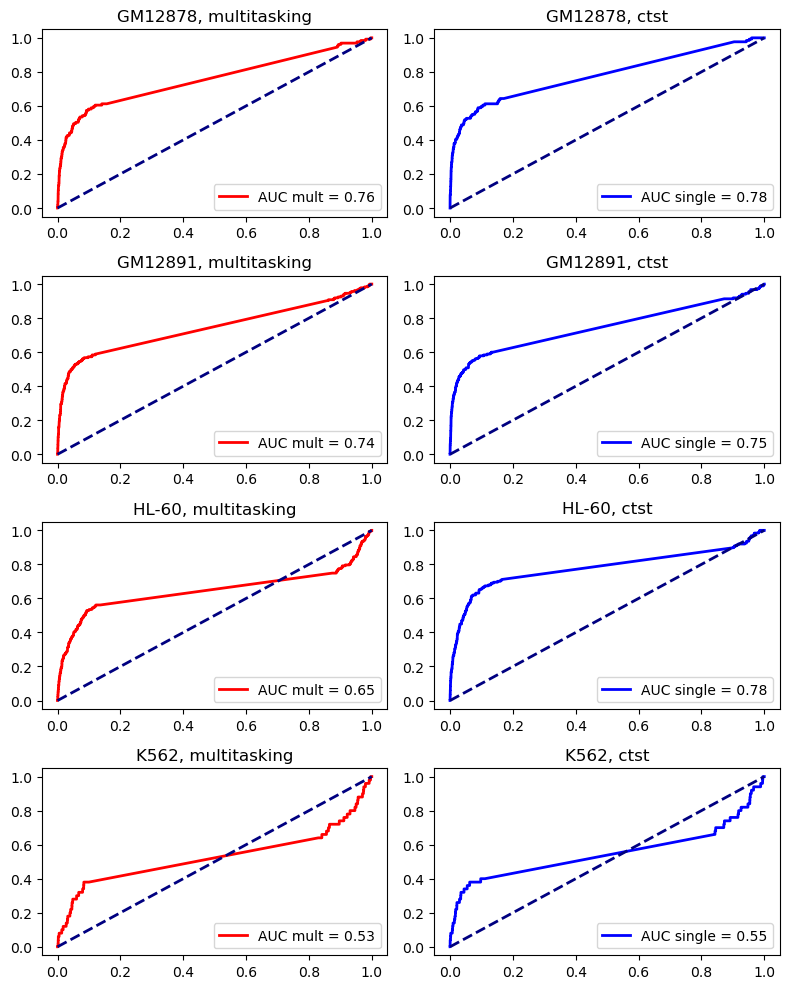

In [6]:
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    fpr, tpr, _ = roc_curve(labels, full_vector)
    roc_auc = roc_auc_score(labels, full_vector)
    fpr_mult, tpr_mult, _ = roc_curve(labels, full_vector_mult)
    roc_auc_mult = roc_auc_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC single = {roc_auc:.2f}')
    ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="lower right")

    ax[row, 0].plot(fpr_mult, tpr_mult, color='red', lw=2, label=f'AUC mult = {roc_auc_mult:.2f}')
    ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="lower right")

# Adjust layout
fig.tight_layout()
plt.show()
    

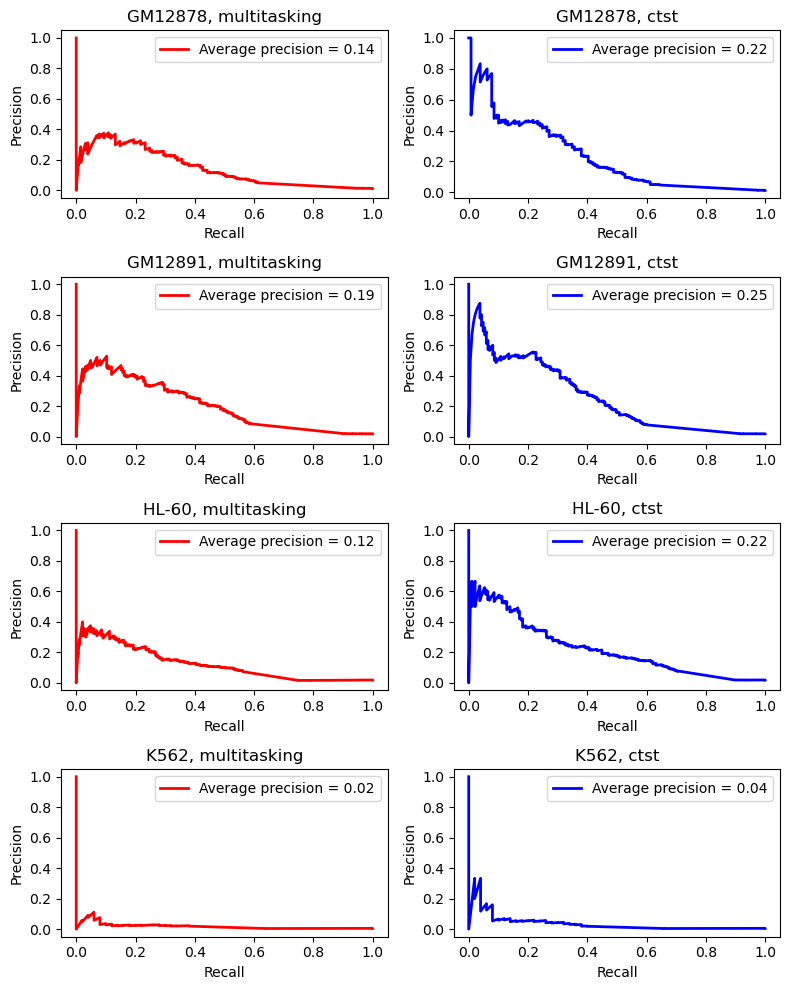

In [7]:
#now the real task is calculating the prc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    precision,recall,_ = precision_recall_curve(labels, full_vector)

    roc_auc = average_precision_score(labels, full_vector)
    precision_mult,recall_mult, _ = precision_recall_curve(labels, full_vector_mult)
    roc_auc_mult = average_precision_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(recall,precision, color='blue', lw=2, label=f'Average precision = {roc_auc:.2f}')
    # ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="upper right")
    ax[row, 1].set_xlabel('Recall')
    ax[row, 1].set_ylabel('Precision')

    ax[row, 0].plot(recall_mult, precision_mult, color='red', lw=2, label=f'Average precision = {roc_auc_mult:.2f}')
    # ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="upper right")
    ax[row, 0].set_xlabel('Recall')
    ax[row, 0].set_ylabel('Precision')

# Adjust layout
fig.tight_layout()
plt.show()

In [8]:
#let's just try 200
#we can literally just make a list of this for the k562 cell!!
#and then do a for loop, but let's make this for the k562 cell first
from tqdm import tqdm
all_list = []
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
    print(file)
    celltype_list = []
    for tf_peak in tqdm(range(len(df)), total = len(df)):
        peak = df[tf_peak,:]
        peak_start = peak['start'][0]
        peak_end = peak['stop'][0]
        chromosome = peak['chr'][0]
        subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
        start = subset_df['start'].to_numpy()
        start = start-peak_start
        # close = np.abs(start)<500
        close = np.abs(start)<200
        locations = np.where(close)[0] #provides all the locations
        if len(locations)==0: #if there's no locations we don't care
            continue
        #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
        newdf = subset_df[locations,:]
        for i in range(len(newdf)):
            celltype_list.append(newdf['id1'][i])
    all_list.append(celltype_list)
# print(len(k562_list))

GM12878.bed


100%|██████████| 44283/44283 [00:28<00:00, 1553.94it/s]


GM12891.bed


100%|██████████| 54271/54271 [00:27<00:00, 1983.36it/s]


HL60.bed


100%|██████████| 63379/63379 [00:29<00:00, 2145.40it/s]


K562.bed


100%|██████████| 32606/32606 [00:15<00:00, 2144.75it/s]


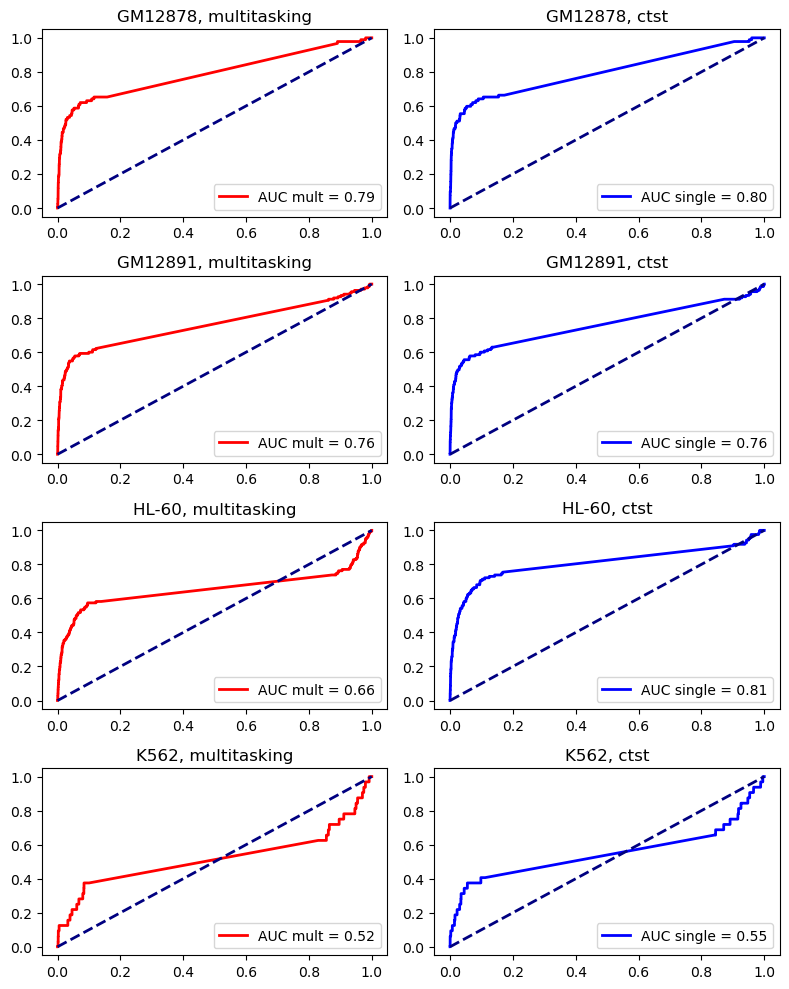

In [9]:
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    fpr, tpr, _ = roc_curve(labels, full_vector)
    roc_auc = roc_auc_score(labels, full_vector)
    fpr_mult, tpr_mult, _ = roc_curve(labels, full_vector_mult)
    roc_auc_mult = roc_auc_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC single = {roc_auc:.2f}')
    ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="lower right")

    ax[row, 0].plot(fpr_mult, tpr_mult, color='red', lw=2, label=f'AUC mult = {roc_auc_mult:.2f}')
    ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="lower right")

# Adjust layout
fig.tight_layout()
plt.show()
    

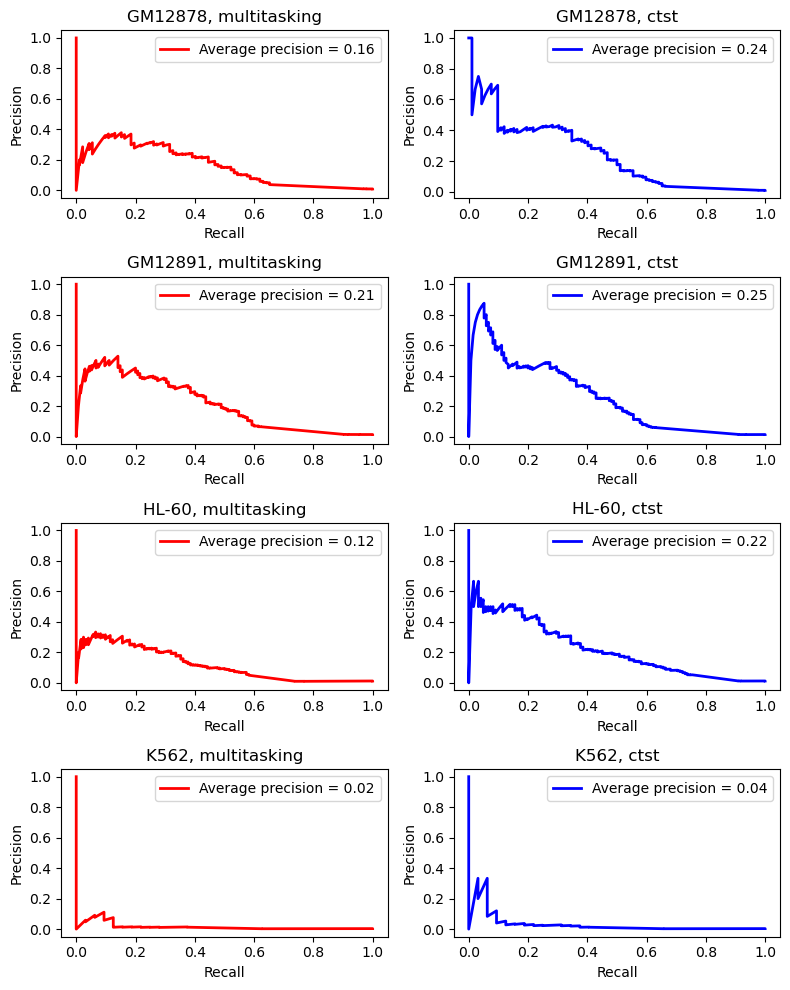

In [10]:
#now the real task is calculating the prc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    precision,recall,_ = precision_recall_curve(labels, full_vector)

    roc_auc = average_precision_score(labels, full_vector)
    precision_mult,recall_mult, _ = precision_recall_curve(labels, full_vector_mult)
    roc_auc_mult = average_precision_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(recall,precision, color='blue', lw=2, label=f'Average precision = {roc_auc:.2f}')
    # ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="upper right")
    ax[row, 1].set_xlabel('Recall')
    ax[row, 1].set_ylabel('Precision')

    ax[row, 0].plot(recall_mult, precision_mult, color='red', lw=2, label=f'Average precision = {roc_auc_mult:.2f}')
    # ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="upper right")
    ax[row, 0].set_xlabel('Recall')
    ax[row, 0].set_ylabel('Precision')

# Adjust layout
fig.tight_layout()
plt.show()

In [11]:
#wait, we have been doing it form the start, but it should be between the start and end!!
#let's just try 200
#we can literally just make a list of this for the k562 cell!!
#and then do a for loop, but let's make this for the k562 cell first
from tqdm import tqdm
all_list = []
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
    print(file)
    celltype_list = []
    for tf_peak in tqdm(range(len(df)), total = len(df)):
        peak = df[tf_peak,:]
        peak_start = peak['start'][0]
        peak_end = peak['stop'][0]
        peak_middle = (peak_start+peak_end)//2
        chromosome = peak['chr'][0]
        subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
        middle = (subset_df['start'].to_numpy() + subset_df['stop'].to_numpy()) // 2
        middle = middle-peak_start
        # close = np.abs(start)<500
        close = np.abs(middle)<300
        locations = np.where(close)[0] #provides all the locations
        if len(locations)==0: #if there's no locations we don't care
            continue
        #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
        newdf = subset_df[locations,:]
        for i in range(len(newdf)):
            celltype_list.append(newdf['id1'][i])
    all_list.append(celltype_list)
# print(len(k562_list))

GM12878.bed


100%|██████████| 44283/44283 [00:22<00:00, 2006.42it/s]


GM12891.bed


100%|██████████| 54271/54271 [00:27<00:00, 2005.06it/s]


HL60.bed


100%|██████████| 63379/63379 [00:31<00:00, 2000.76it/s]


K562.bed


100%|██████████| 32606/32606 [00:16<00:00, 2004.44it/s]


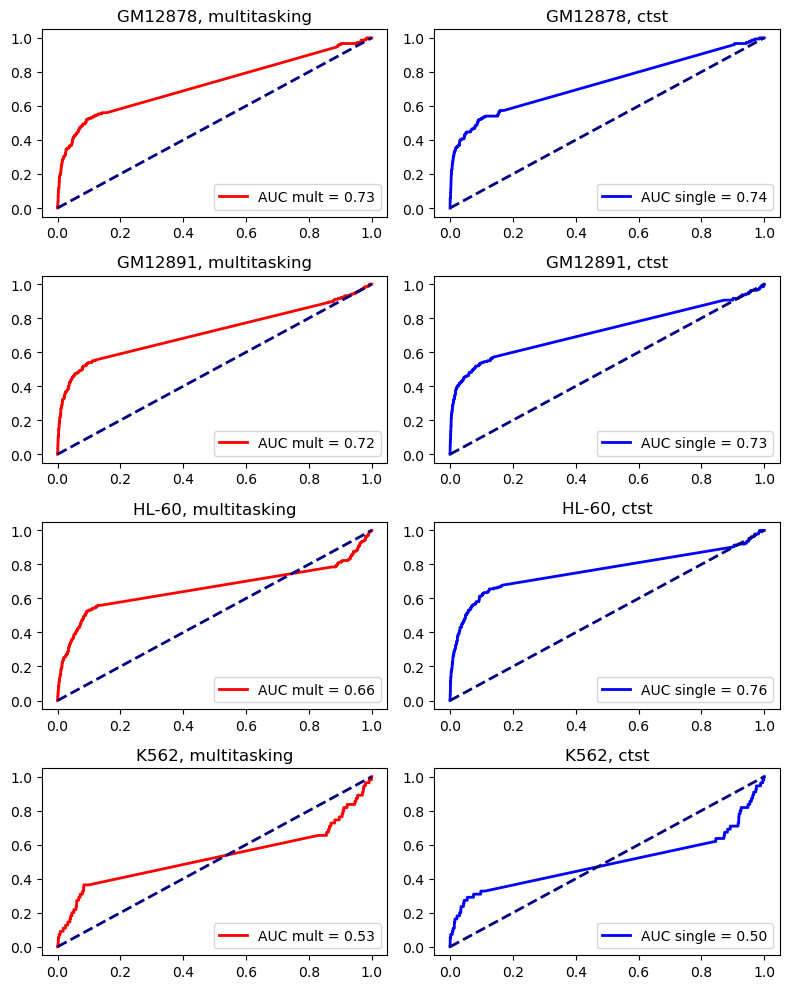

In [12]:
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    fpr, tpr, _ = roc_curve(labels, full_vector)
    roc_auc = roc_auc_score(labels, full_vector)
    fpr_mult, tpr_mult, _ = roc_curve(labels, full_vector_mult)
    roc_auc_mult = roc_auc_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC single = {roc_auc:.2f}')
    ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="lower right")

    ax[row, 0].plot(fpr_mult, tpr_mult, color='red', lw=2, label=f'AUC mult = {roc_auc_mult:.2f}')
    ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="lower right")

# Adjust layout
fig.tight_layout()
plt.show()
    

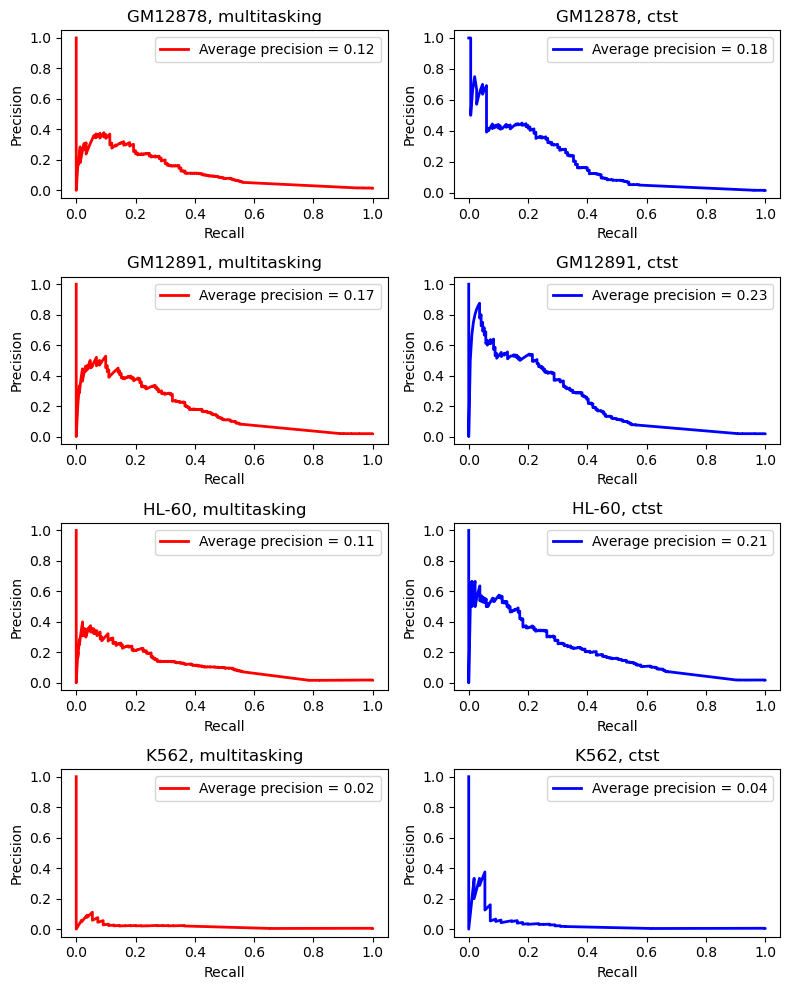

In [13]:
#now the real task is calculating the prc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    precision,recall,_ = precision_recall_curve(labels, full_vector)

    roc_auc = average_precision_score(labels, full_vector)
    precision_mult,recall_mult, _ = precision_recall_curve(labels, full_vector_mult)
    roc_auc_mult = average_precision_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(recall,precision, color='blue', lw=2, label=f'Average precision = {roc_auc:.2f}')
    # ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="upper right")
    ax[row, 1].set_xlabel('Recall')
    ax[row, 1].set_ylabel('Precision')

    ax[row, 0].plot(recall_mult, precision_mult, color='red', lw=2, label=f'Average precision = {roc_auc_mult:.2f}')
    # ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="upper right")
    ax[row, 0].set_xlabel('Recall')
    ax[row, 0].set_ylabel('Precision')

# Adjust layout
fig.tight_layout()
plt.show()

In [14]:
#wait, we have been doing it form the start, but it should be between the start and end!!
#let's just try 200
#we can literally just make a list of this for the k562 cell!!
#and then do a for loop, but let's make this for the k562 cell first
from tqdm import tqdm
all_list = []
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
    print(file)
    celltype_list = []
    for tf_peak in tqdm(range(len(df)), total = len(df)):
        peak = df[tf_peak,:]
        peak_start = peak['start'][0]
        peak_end = peak['stop'][0]
        peak_middle = (peak_start+peak_end)//2
        chromosome = peak['chr'][0]
        subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
        middle = (subset_df['start'].to_numpy() + subset_df['stop'].to_numpy()) // 2
        middle = middle-peak_middle
        # close = np.abs(start)<500
        close = np.abs(middle)<300
        locations = np.where(close)[0] #provides all the locations
        if len(locations)==0: #if there's no locations we don't care
            continue
        #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
        newdf = subset_df[locations,:]
        for i in range(len(newdf)):
            celltype_list.append(newdf['id1'][i])
    all_list.append(celltype_list)
# print(len(k562_list))

GM12878.bed


100%|██████████| 44283/44283 [00:22<00:00, 2006.84it/s]


GM12891.bed


100%|██████████| 54271/54271 [00:27<00:00, 2006.42it/s]


HL60.bed


100%|██████████| 63379/63379 [00:31<00:00, 2001.15it/s]


K562.bed


100%|██████████| 32606/32606 [00:16<00:00, 2000.03it/s]


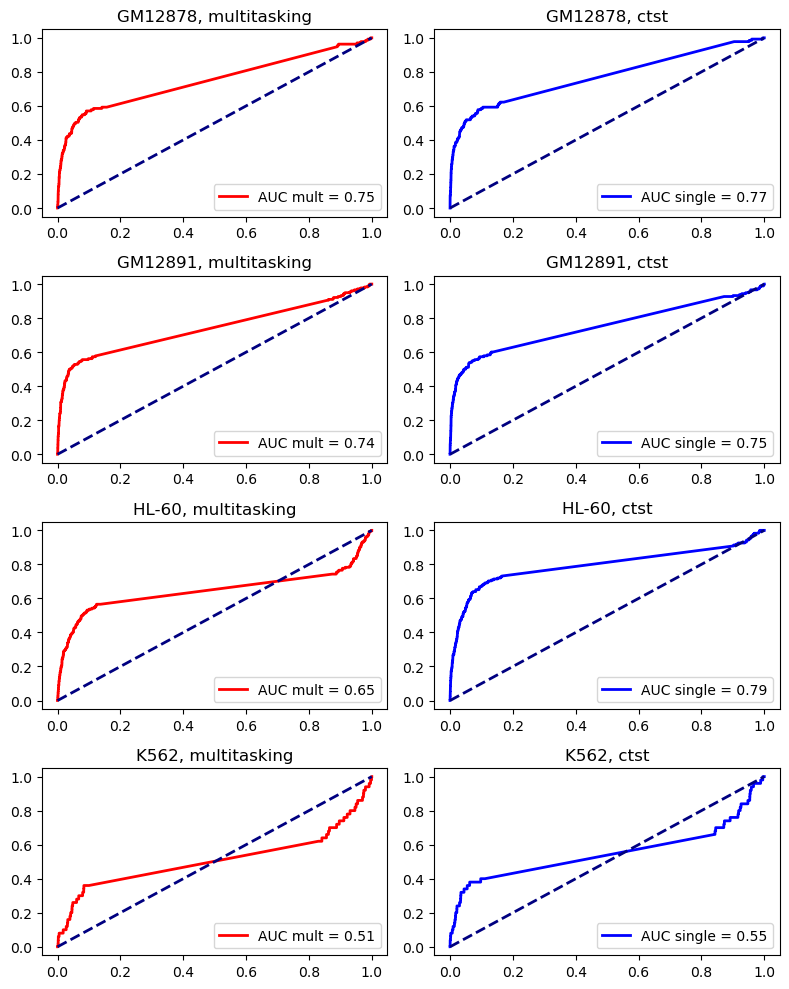

In [15]:
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    fpr, tpr, _ = roc_curve(labels, full_vector)
    roc_auc = roc_auc_score(labels, full_vector)
    fpr_mult, tpr_mult, _ = roc_curve(labels, full_vector_mult)
    roc_auc_mult = roc_auc_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC single = {roc_auc:.2f}')
    ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="lower right")

    ax[row, 0].plot(fpr_mult, tpr_mult, color='red', lw=2, label=f'AUC mult = {roc_auc_mult:.2f}')
    ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="lower right")

# Adjust layout
fig.tight_layout()
plt.show()
    

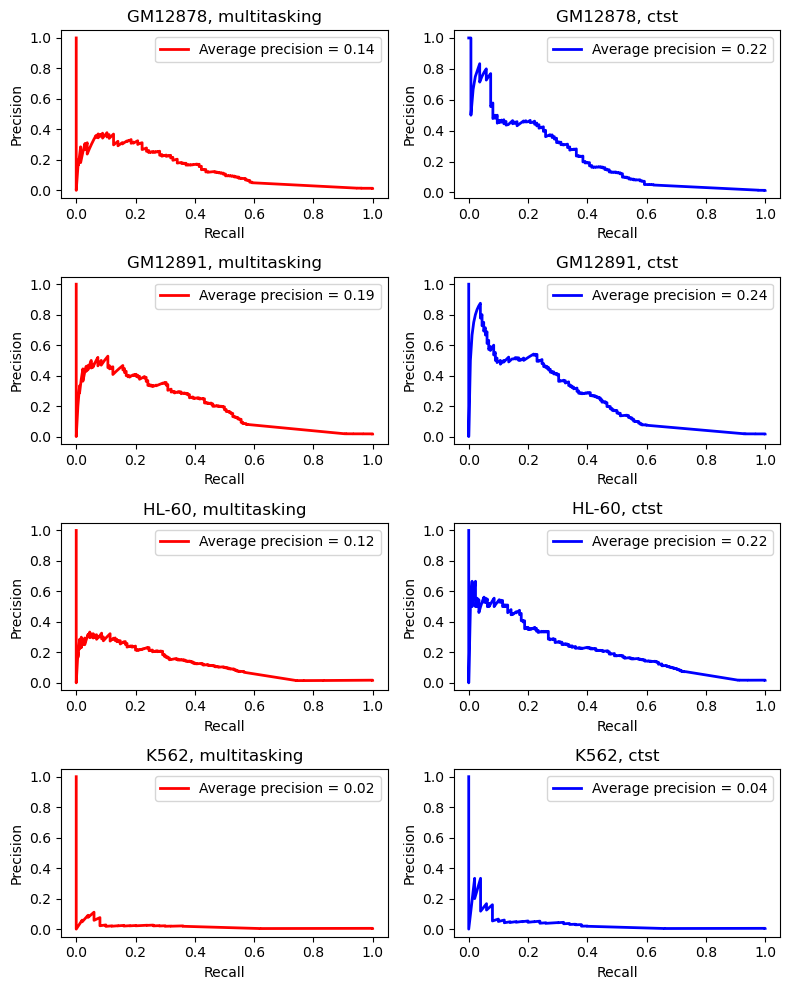

In [16]:
#now the real task is calculating the prc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    precision,recall,_ = precision_recall_curve(labels, full_vector)

    roc_auc = average_precision_score(labels, full_vector)
    precision_mult,recall_mult, _ = precision_recall_curve(labels, full_vector_mult)
    roc_auc_mult = average_precision_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(recall,precision, color='blue', lw=2, label=f'Average precision = {roc_auc:.2f}')
    # ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="upper right")
    ax[row, 1].set_xlabel('Recall')
    ax[row, 1].set_ylabel('Precision')

    ax[row, 0].plot(recall_mult, precision_mult, color='red', lw=2, label=f'Average precision = {roc_auc_mult:.2f}')
    # ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="upper right")
    ax[row, 0].set_xlabel('Recall')
    ax[row, 0].set_ylabel('Precision')

# Adjust layout
fig.tight_layout()
plt.show()

In [ ]:
#this last one is the proper one, and looks about as promising as the rest, overall very solid!
#better for all these celltypes by noticeable amount, or signal so bad it's basically 0!!

#this is great to see!

# we have some good results

Let's try to repeat it on other celltypes

In [ ]:
#